## SALES ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

### `Merging 12 Months of data` 

In [2]:
files = [file for file in os.listdir('./Sales_Data/')]
all_paths = [os.path.join('./Sales_Data/',f) for f in files]

data = pd.concat(map(pd.read_csv,all_paths))
data.to_csv("./Sales_Data/all_months_data.csv",index=False)

In [3]:
all_data = pd.read_csv('./Sales_Data/all_months_data.csv',index_col=False)
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22:30,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1,600,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1,11.99,04-12-2019 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


## `Basic Exploration`

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186849 entries, 0 to 186848
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


## `Observation:`
=========================================================================================================================

###  We can see that data type for Quantity and Price are set as Objects although they can't be used as categorical data. Therefore we need to change the dtype for these features

========================================================================================================================


## DATA CLEANING 

### `Approach:`

 Step 1:  We check for unique values of the featuers, to check if any other value apart from number exsits. This is not suitable for all feauters but for Quantity we assume that range of values  will not be large.

 Step 2: We remove any anomaly we find and convert the datatype of Price Each and Quanitity Ordered to float from str

 Step3: Next we check if there exists any nan values (missing data) and remove it from the dataset

 Step4:  We can also observe Order Date as one feature which is set as str. Looking at the value we can clearly see that these 			represent timestamp values. Therefore we will convert them to timestamp object from str


In [5]:
#Let's check unique values of quantity 
all_data['Quantity Ordered'].unique()

array(['2', '1', '3', nan, '5', 'Quantity Ordered', '4', '7', '6', '8',
       '9'], dtype=object)

In [6]:
#since there is a str which cannoted be converted to float we will remove it
all_data = (all_data[~(all_data['Quantity Ordered'] == 'Quantity Ordered')])
all_data['Quantity Ordered'] = all_data['Quantity Ordered'].astype(float)
all_data['Price Each'] = all_data['Price Each'].astype(float)

In [7]:
all_data.dtypes

Order ID             object
Product              object
Quantity Ordered    float64
Price Each          float64
Order Date           object
Purchase Address     object
dtype: object

In [8]:
#check for null values
all_data.isnull().sum()

Order ID            544
Product             544
Quantity Ordered    544
Price Each          544
Order Date          544
Purchase Address    544
dtype: int64

In [9]:
#drop nan values
all_data.dropna(inplace=True)

In [10]:
all_data.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [11]:
#reset index for data
all_data.reset_index(drop=True,inplace=True)

In [12]:
#convert each value of order date to datetime value
all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])

## FEATURE ENGINEERING

### `Approach`

1. We can create various features from existing ones so that our task of extracting insights become easier.
2. We have created 'Month' by extracting month from timestamps in Order Date
3. We have created 'Sales' by multiplying quantity and price each product
4. We have also created city by extracting it from Purchase order in the form City_Name (City_code)
5. Lastly, we created two feauters 'Hour' and 'Minutes' by extracting it from timestamps

In [13]:
def get_city(address):
    city = address.split(',')[1]
    code = address[-8:-6]
    return city+' '+'('+code+')'

all_data['City'] = all_data['Purchase Address'].apply(get_city)
all_data['Month'] = all_data['Order Date'].apply(lambda x:x.month)
all_data['Sales'] = all_data['Quantity Ordered']*all_data['Price Each']
all_data['Hour'] = all_data['Order Date'].dt.hour
all_data['Minutes'] = all_data['Order Date'].dt.minute
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,Month,Sales,Hour,Minutes
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",Dallas (TX),4,23.90,8,46
1,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",Boston (MA),4,99.99,22,30
2,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",Los Angeles (CA),4,600.00,14,38
3,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",Los Angeles (CA),4,11.99,14,38
4,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",Los Angeles (CA),4,11.99,9,27


## OUTLIER ANALYSIS

### `Approach:`

1. First, we get the statistical data about the continous features
2. Here we will only focus on sales, quantity and Pirce each product.

In [14]:
all_data.describe()

,Quantity Ordered,Price Each,Month,Sales,Hour,Minutes
count,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000
mean,1.124383,184.399735,7.059140,185.490917,14.413305,29.481361
std,0.442793,332.731330,3.502996,332.919771,5.423416,17.317573
min,1.000000,2.990000,1.000000,2.990000,0.000000,0.000000
25%,1.000000,11.950000,4.000000,11.950000,11.000000,14.000000
50%,1.000000,14.950000,7.000000,14.950000,15.000000,29.000000
75%,1.000000,150.000000,10.000000,150.000000,19.000000,45.000000
max,9.000000,1700.000000,12.000000,3400.000000,23.000000,59.000000


In [15]:
def iqr_analysis(x):
    q1 = np.quantile(x,0.25)
    q3 = np.quantile(x,0.75)
    
    iqr = q3-q1
    
    lower_limit = q1-1.5*iqr
    upper_limit = q3+1.5*iqr
    
    return lower_limit,upper_limit

In [16]:
lw, up = iqr_analysis(all_data['Price Each'])
amt = len(all_data[(all_data['Price Each']<lw) | (all_data['Price Each']>up)])
total_datapoints = len(all_data)
print("Amount of data where Pirce Each is outlier according to IQR Analysis:",amt,end = " ")
print(f"which is {round((amt/total_datapoints)*100,2)}% of total_data")

Amount of data where Pirce Each is outlier according to IQR Analysis: 37007 which is 19.9% of total_data


## `Observation:`

=========================================================================================================================	
	 
Here we can observe that data for quantity doesnt range much (1-9). For Price, we see that there is a huge difference from 75 percentile of data to maximum of it. But if we get a closer look more than 20% data belongs to datapoints which are greater than 75 percentile. Therefore we should not consider these outliers as they seem to be naturally occuring. The same can be verfied using IQR analysis
     
========================================================================================================================


### Visualizing (not-so)Outliers

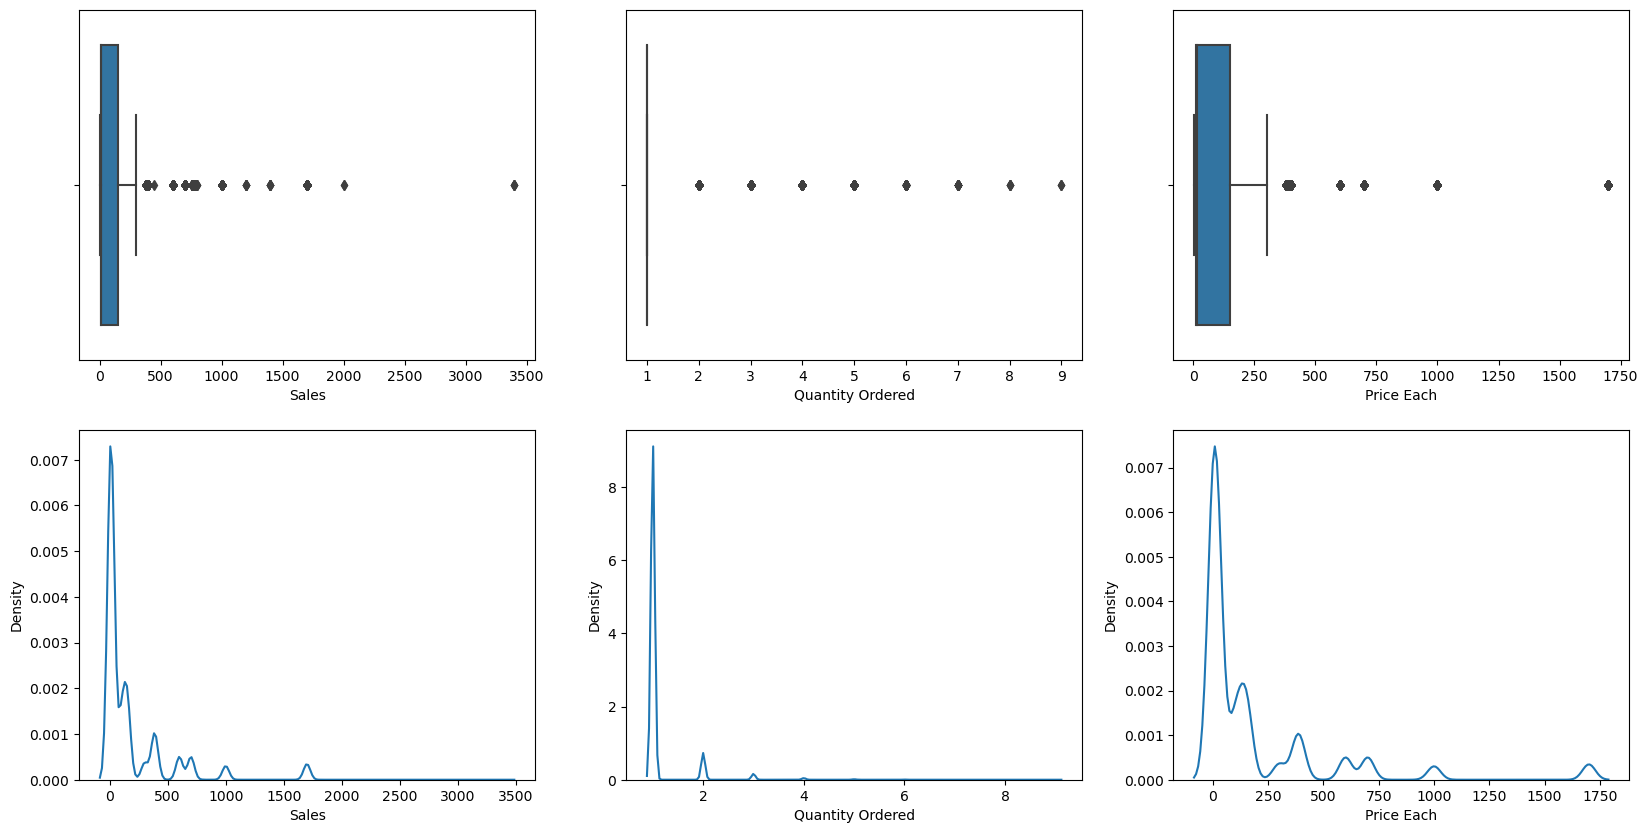

In [17]:
labels = ['Sales','Quantity Ordered','Price Each']
c=0
plt.figure(figsize=(20,10))
for i in labels*2:
    c=c+1
    plt.subplot(2,3,c)
    if c<=3:
        sns.boxplot(x=all_data[i])
    else:
        sns.kdeplot(x=all_data[i])
    
plt.show()

## DATA WRANGLING

## What was the best month for sales? How much was earned that month


In [18]:
results = all_data.groupby('Month').sum()

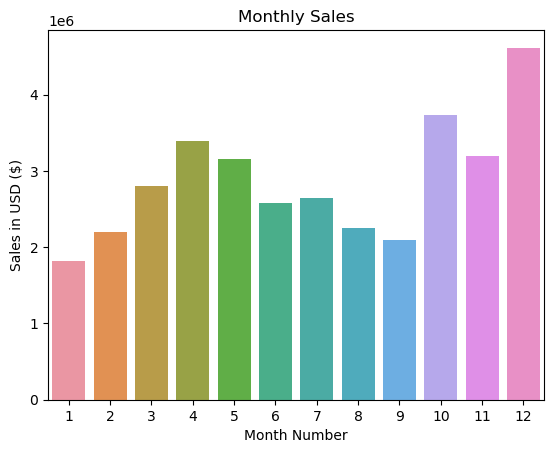

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
months = range(1,13)
sns.barplot(x=results.index,y='Sales',data=results)
plt.xlabel('Month Number')
plt.ylabel('Sales in USD ($)')
plt.title('Monthly Sales')
plt.show()

### `RESULT: `

=====================================================================================================================

We can see that December (12) contributed to most sales. This can assmued due to the festive period of the year, owing to christmas and new year's eve

======================================================================================================================

### What city had highest number of sales

In [20]:
results = all_data.groupby('City').sum()

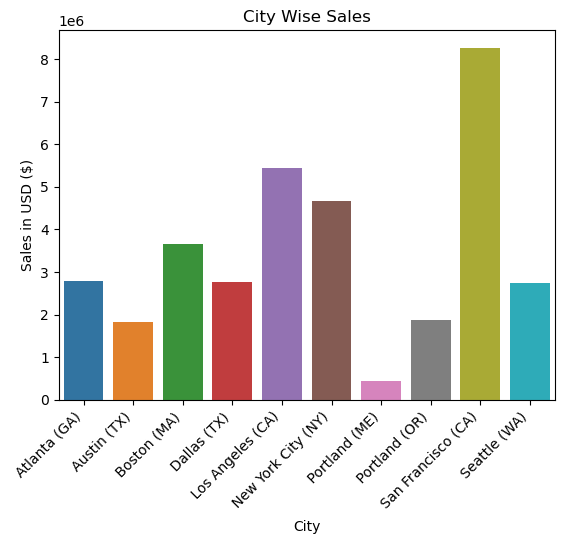

In [21]:
sns.barplot(x=results.index,y='Sales',data=results)
plt.xlabel('City')
plt.ylabel('Sales in USD ($)')
plt.title('City Wise Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

### `RESULT: `

=====================================================================================================================

We can see that San Francisco (SA) contributed to most sales. This might correlate of Population or percapita income 

======================================================================================================================

### What time should we display ads to maximise liklihood of customer's buying product

In [22]:
hours = [hour for hour, df in all_data.groupby('Hour')]

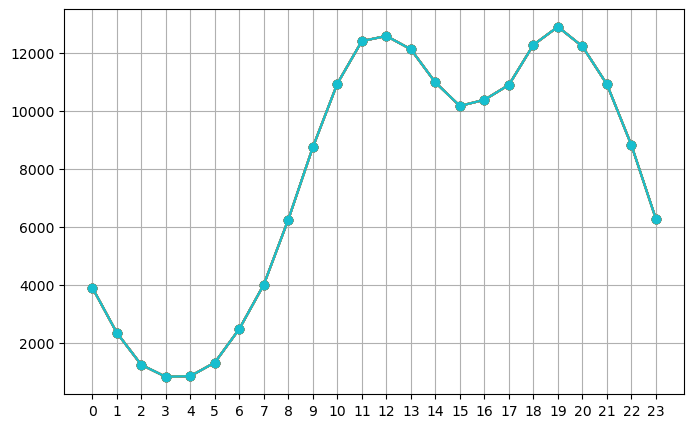

In [23]:
fig = plt.figure(figsize=(8,5))
plt.plot(hours,all_data.groupby('Hour').count(),marker='o')
plt.xticks(hours)
plt.grid()
plt.show()




### `RESULT: `

=====================================================================================================================

Here we can observe that between 11AM-12AM and 6PM-8PM number of orders are high. Therefore we can safely assume these times to be good for ads to increase maximum liklihood of customer buying the product

======================================================================================================================

### What products are most often sold together?

In [24]:
df = all_data[all_data['Order ID'].duplicated(keep=False)]
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df = df[['Order ID','Grouped']].drop_duplicates()

count = Counter()

for row in df['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list,2)))

for key, value in count.most_common(10):
    print(key,value)
    


('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


### `RESULT: `

=====================================================================================================================

Therefore, Iphone and lightning Charging Cable mostly sold together
 
======================================================================================================================

## What product sold the most? Why do you think it sold the most?

In [25]:
results = all_data.groupby('Product').sum()['Quantity Ordered']

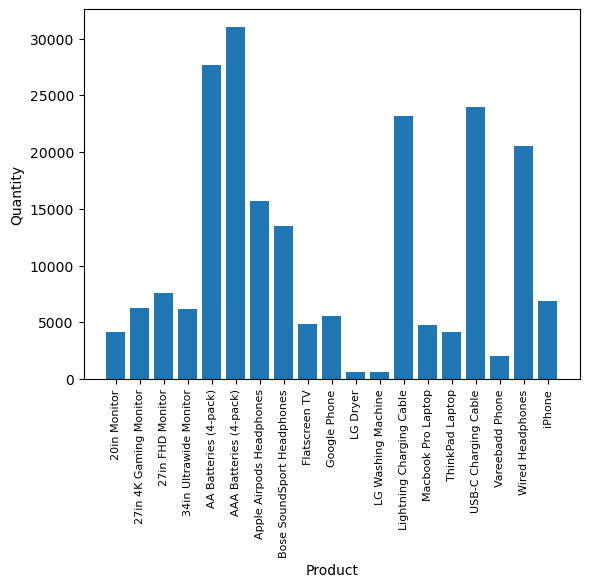

In [26]:
plt.bar(results.index,results)
plt.xticks(rotation=90, size=8)
plt.ylabel('Quantity')
plt.xlabel('Product')
plt.show()

### `RESULT: `

=====================================================================================================================

We can see that AAA Batteries (4-PACK) are sold the most. It might be because it is cheaper. We will see that in next plot

======================================================================================================================

In [27]:
prices = all_data.groupby('Product').mean()['Price Each']

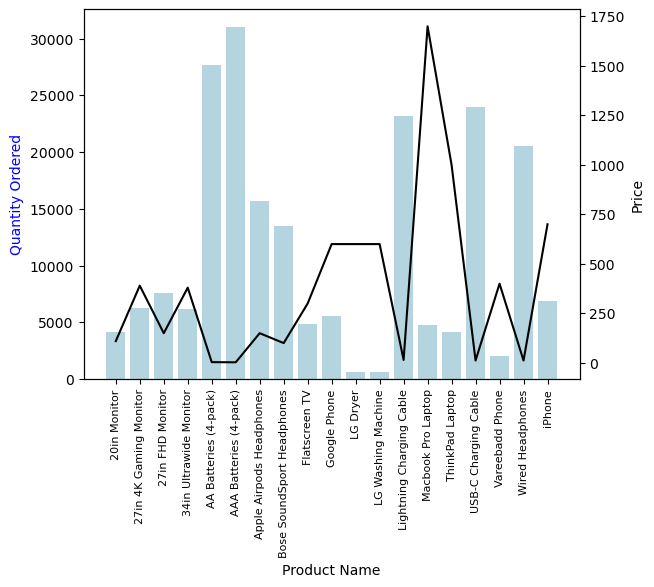

In [28]:
fig, ax1 = plt.subplots()

sns.barplot(x=results.index, y=results, ax=ax1, color='lightblue')

ax2 = ax1.twinx()

sns.lineplot(x=prices.index, y=prices, ax=ax2, color='black')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity Ordered', color='blue')
ax2.set_ylabel('Price', color='black')
ax1.set_xticklabels(results.index, rotation=90, size=8)

plt.show()


### `RESULT: `

=====================================================================================================================

Here, we can see correlation between PRICE and Quantity Ordered. We can observe that there is a price correlation with the demand of product. Although it is partially true, because even though prices for MacBook and Thinkpad seens to high, there is some demand for product. Therefore price solely doesnt control demand but is a significant factor for demand

======================================================================================================================